# Notebook to convert halo field functions for array use

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### General constants

In [2]:
kPi = np.pi
kTwoPi = 2 * kPi
degree = kPi / 180.
kpc = 1
microgauss = 1
megayear = 1
Gpc = 1e6 * kpc
pc = 1e-3 * kpc
second = megayear / (1e6 * 60 * 60 * 24 * 365.25)
kilometer = kpc / 3.0856775807e+16

### General functions

In [3]:
def sigmoid(x, x0, w):
    """
    Calculates the logistic sigmoid function.
    Arguments:
    x : float
        The input value
    x0 : float
        The midpoint of the sigmoid
    w : float
        The width of the sigmoid
    
    Returns:
    The result of the sigmoid function
    """
    return 1 / (1 + np.exp(-(x - x0) / w))

def delta_phi(phi0, phi1):
    """
    Calculates the angle between v0 = (cos(phi0), sin(phi0)) and v1 = (cos(phi1), sin(phi1)).
    Arguments:
    phi0 : float
        First angle in radians
    phi1 : float
        Second angle in radians
    
    Returns:
    The angle between v0 and v1 in radians.
    """
    return np.arccos(np.cos(phi1) * np.cos(phi0) + np.sin(phi1) * np.sin(phi0))

def signum(x):
    """Return the sign of each entry of an array"""
    return (x < 0.) * -1. + (x >= 0) * 1.

# Toroidal halo field

Paramters for base model

In [4]:
fPoloidalA    =  1 * Gpc

fDiskB1        =  1.0878565e+00 * microgauss
fDiskB2        =  2.6605034e+00 * microgauss
fDiskB3        =  3.1166311e+00 * microgauss
fDiskH         =  7.9408965e-01 * kpc
fDiskPhase1    =  2.6316589e+02 * degree
fDiskPhase2    =  9.7782269e+01 * degree
fDiskPhase3    =  3.5112281e+01 * degree
fDiskPitch     =  1.0106900e+01 * degree
fDiskW         =  1.0720909e-01 * kpc
fPoloidalB     =  9.7775487e-01 * microgauss
fPoloidalP     =  1.4266186e+00 * kpc
fPoloidalR     =  7.2925417e+00 * kpc
fPoloidalW     =  1.1188158e-01 * kpc
fPoloidalZ     =  4.4597373e+00 * kpc
fStriation     =  3.4557571e-01
fToroidalBN    =  3.2556760e+00 * microgauss
fToroidalBS    = -3.0914569e+00 * microgauss
fToroidalR     =  1.0193815e+01 * kpc
fToroidalW     =  1.6936993e+00 * kpc
fToroidalZ     =  4.0242749e+00 * kpc

fSinPitch = np.sin(fDiskPitch)
fCosPitch = np.cos(fDiskPitch)
fTanPitch = np.tan(fDiskPitch)

In [5]:
def get_toroidal_halo_field_cyl(rho, z):
    
    if not rho.shape[0] == z.shape[0]:
        raise ValueError("List do not have equal shape! returning -1")

    b0 = np.where(z>=0, fToroidalBN, fToroidalBS)
    rh = fToroidalR
    z0 = fToroidalZ
    fwh = fToroidalW
    sigmoid_r = sigmoid(rho, rh, fwh)
    sigmoid_z = sigmoid(np.abs(z), fDiskH, fDiskW)

    # Eq. (21)
    b_phi = b0 * (1 - sigmoid_r) * sigmoid_z * np.exp(-np.abs(z) / z0)


    b_cyl = np.zeros((3, len(rho)))
    b_cyl[1, :] = b_phi

    return b_cyl

### Testing

In [6]:
x = np.linspace(-20, 20, 401)
y = np.linspace(-20, 20, 101)
z = np.linspace(-20, 20, 401)

xx,yy,zz = np.meshgrid(x, y, z, indexing='ij')

rr = np.sqrt(xx ** 2. + yy ** 2.) # rho component
pp = np.arctan2(yy, xx) # phi component

idy = np.argmin(np.abs(y))

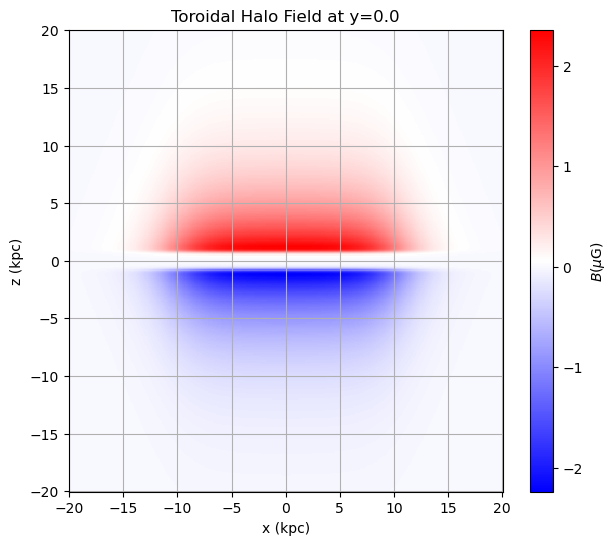

In [7]:
Bhalo = np.zeros_like(rr[:,idy,:])

for i,r in enumerate(rr[:,idy,:]):
    B = get_toroidal_halo_field_cyl(rho=r, z=zz[i,idy,:]) 
    Bhalo[i,:] = np.sqrt(np.sum(B**2., axis=0))*signum(B[1,:])


plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo, cmap=plt.cm.bwr, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

plt.title(f"Toroidal Halo Field at y={y[idy]}")
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.grid()

plt.show()


# Poloidal halo field

Also using parameters for base model

In [8]:
fModelType = "base"
def get_poloidal_halo_field_cyl(rho, z):

    if not rho.shape[0] == z.shape[0]:
        raise ValueError("List do not have equal shape! returning -1")

    c = np.power((fPoloidalA / fPoloidalZ), fPoloidalP)
    a0p = np.power(fPoloidalA, fPoloidalP)
    rp = np.power(rho, fPoloidalP)
    abszp = np.power(np.abs(z), fPoloidalP)
    cabszp = c * abszp

    t0 = a0p + cabszp - rp
    t1 = np.sqrt(t0**2 + 4 * a0p * rp)
    ap = 2 * a0p * rp / (t1 + t0)

    if np.any(ap < 0) and np.any(rho > np.finfo(float).eps):
        # This should never happen
        raise ValueError("ap = {}".format(ap))
    
    a = np.power(np.maximum(ap, 0), 1 / fPoloidalP)
    
    # Eq. 29 and Eq. 32
    if fModelType == 'expX':
        radial_dependence = np.exp(-a / fPoloidalR)
    else:
        radial_dependence = 1 - sigmoid(a, fPoloidalR, fPoloidalW)

    # Eq. 28
    bzz = fPoloidalB * radial_dependence

    # r / a
    r_over_a = 1 / np.power((2 * a0p / (t1 + t0)), (1 / fPoloidalP))
    
    # Eq. 35 for p=n
    sign_z = np.where(z < 0, -1, 1)
    br = bzz * c * a / r_over_a * sign_z * np.abs(z)**(fPoloidalP - 1) / t1

    # Eq. 36 for p=n
    bz = bzz * r_over_a**(fPoloidalP - 2) * (ap + a0p) / t1
    
    small_rho = rho < np.finfo(float).eps
    br[small_rho] = 0  # Set radial component to zero where rho is small

    b_cyl = np.zeros((3, rho.size))
    b_cyl[0, :] = br  # Radial component
    b_cyl[2, :] = bz  # Vertical component

    return b_cyl

### Testing

In [9]:
x = np.linspace(-20, 20, 401)
y = np.linspace(-20, 20, 101)
z = np.linspace(-20, 20, 401)

xx,yy,zz = np.meshgrid(x, y, z, indexing='ij') 

rr = np.sqrt(xx ** 2. + yy ** 2.) # rho component
pp = np.arctan2(yy, xx) # phi component

idy = np.argmin(np.abs(y))

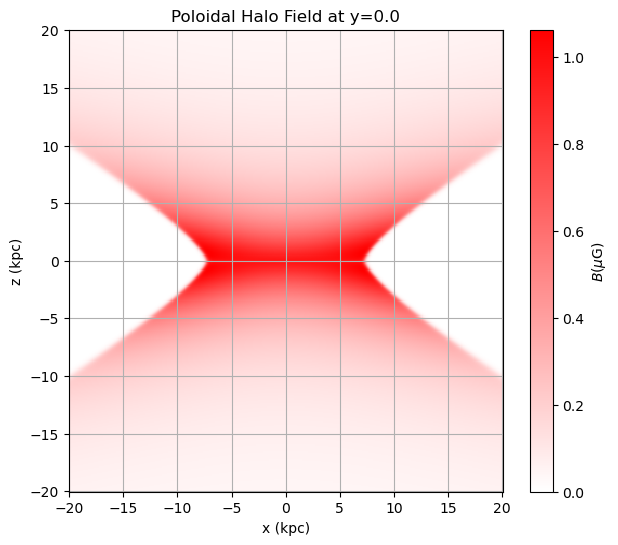

In [10]:
Bhalo = np.zeros_like(rr[:,idy,:])
Bx = np.zeros_like(rr[:,idy,:])
Bz = np.zeros_like(rr[:,idy,:])

for i,r in enumerate(rr[:,idy,:]):
    B = get_poloidal_halo_field_cyl(rho=r, z=zz[i,idy,:])
    Bx[i,:] = B[0]
    Bz[i,:] = B[2]
    Bhalo[i,:] = np.sqrt(np.sum(B**2., axis=0))*signum(B[1,:])

cmap0 = LinearSegmentedColormap.from_list('', ['white', 'red'])

plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo, cmap=cmap0, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')
# plt.streamplot(xx[:,idy,:], zz[:,idy,:], Bx, Bz, broken_streamlines=False, density=0.35)

plt.title(f"Poloidal Halo Field at y={y[idy]}")
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.grid()

plt.show()

# Twisted Halo Field

Paramters for twistX model

In [11]:
fDiskB1        =  1.3741995e+00 * microgauss
fDiskB2        =  2.0089881e+00 * microgauss
fDiskB3        =  1.5212463e+00 * microgauss
fDiskH         =  9.3806180e-01 * kpc
fDiskPhase1    =  2.3560316e+02 * degree
fDiskPhase2    =  1.0189856e+02 * degree
fDiskPhase3    =  5.6187572e+01 * degree
fDiskPitch     =  1.2100979e+01 * degree
fDiskW         =  1.4933338e-01 * kpc
fPoloidalB     =  6.2793114e-01 * microgauss
fPoloidalP     =  2.3292519e+00 * kpc
fPoloidalR     =  7.9212358e+00 * kpc
fPoloidalW     =  2.9056201e-01 * kpc
fPoloidalZ     =  2.6274437e+00 * kpc
fStriation     =  7.7616317e-01
fTwistingTime  =  5.4733549e+01 * megayear

In [12]:
def get_twisted_halo_field_cyl(rho, z):

    if not rho.shape[0] == z.shape[0]:
        raise ValueError("List do not have equal shape! returning -1")
    
    b_x_cyl = get_poloidal_halo_field_cyl(rho, z)

    # Zerlege die Rückgabe des poloidalen Feldes in dessen Komponenten
    b_r, b_phi, b_z = b_x_cyl

    if fTwistingTime != 0:
        # radial rotation curve parameters (fit to Reid et al 2014)
        v0 = -240 * kilometer / second
        r0 = 1.6 * kpc
        # vertical gradient (Levine+08)
        z0 = 10 * kpc

        # Eq. 43
        fr = 1 - np.exp(-rho / r0)
        # Eq. 44
        t0 = np.exp(2 * np.abs(z) / z0)
        gz = 2 / (1 + t0)

        # Eq. 46
        sign_z = np.where(z < 0, -1, 1)
        delta_z = -sign_z * v0 * fr / z0 * t0 * np.power(gz, 2)
        # Eq. 47
        delta_r = v0 * ((1 - fr) / r0 - fr / np.where(rho == 0, np.inf, rho)) * gz  # vermeide Division durch Null

        # Eq. 45
        b_phi = (b_z * delta_z + b_r * delta_r) * fTwistingTime


    b_cyl_x = np.vstack((b_r, b_phi, b_z))
    b_cyl_x = np.where(rho==0, b_x_cyl, b_cyl_x)
    
    return b_cyl_x

### Testing

In [13]:
x = np.linspace(-20, 20, 401)
y = np.linspace(-20, 20, 101)
z = np.linspace(-20, 20, 401)

xx,yy,zz = np.meshgrid(x, y, z, indexing='ij') 

rr = np.sqrt(xx ** 2. + yy ** 2.) # rho component
pp = np.arctan2(yy, xx) # phi component

idy = np.argmin(np.abs(y))

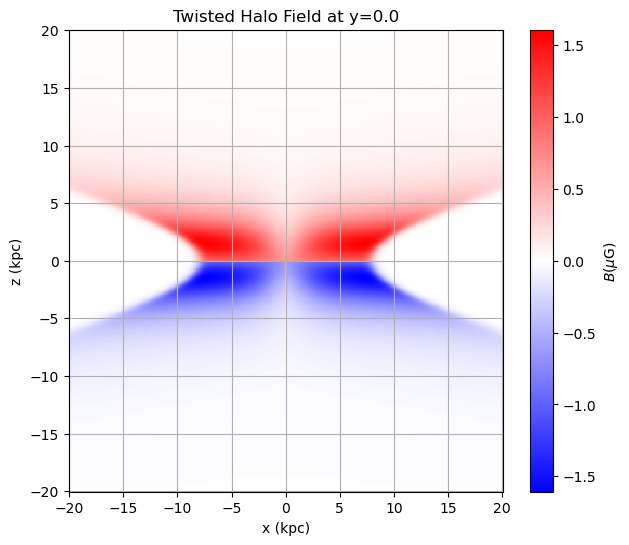

In [14]:
Bhalo = np.zeros_like(rr[:,idy,:])

for i,r in enumerate(rr[:,idy,:]):
    B = get_twisted_halo_field_cyl(rho=r, z=zz[i,idy,:])
    Bhalo[i,:] = np.sqrt(np.sum(B**2., axis=0))*signum(B[1,:])

cmap0 = LinearSegmentedColormap.from_list('', ['white', 'red'])

plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo, cmap=plt.cm.bwr, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

plt.title(f"Twisted Halo Field at y={y[idy]}")
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.grid()

plt.show()